In [54]:
# 데이터 전처리 및 핸들링을 위한 모듈
import pandas as pd
import numpy as np

# 데이터 시각화를 위한 모듈
import matplotlib.pyplot as plt
import seaborn as sns

# 좌표 생성을 위한 모듈
import random
from shapely.geometry import Point, Polygon

# p-median 분석을 위한 모듈
from haversine import haversine
from sklearn.preprocessing import MinMaxScaler
from pulp import *
import folium

# 경고 무시
import warnings
warnings.filterwarnings("ignore")

## 분석 대상 지역 선정 : 침수심 데이터 시각화

- 침수유발 기준강우량 데이터

- 변수설명
    - ID : 아이디(식별을 위한 번호)
    - GID : 격자번호(국가지점번호)
    - SD CD : 시도코드
    - SD NM : 시도명
    - SGG CD : 시군구코드
    - SGG NM : 시군구명
    - INCLINATION : 기울기
    - INTERCEPT : y절편
    - DEPTH 10 : 10cm 침수심 유발 강수량
    - DEPTH 20 : 20cm 침수심 유발 강수량
    - DEPTH 50 : 50cm 침수실 유발 강수량
    
- 침수심을 유발하는 강수량이 적을수록 피해가 큰 구라고 예측할 수 있음

In [4]:
depth = pd.read_csv("./data/침수유발 기준강우량 데이터_2021(서울).csv")

In [5]:
# 구별 10cm, 20cm, 50cm 침수심 확인
depth = depth.groupby("SGG_NM").mean()[["DEPTH_10", "DEPTH_20", "DEPTH_50"]]
df_depth = pd.DataFrame(depth)
df_depth.reset_index(inplace = True)
df_depth

,SGG_NM,DEPTH_10,DEPTH_20,DEPTH_50
0,강남구,65.380536,177.840714,515.236250
1,강동구,179.900000,472.800000,1351.500000
2,강북구,49.510000,166.010000,515.510000
3,강서구,69.379231,226.613692,698.317077
4,관악구,53.834444,248.234444,831.436667
5,광진구,159.889231,425.743077,1223.304615
6,구로구,51.320000,151.520000,452.120000
7,금천구,51.320000,151.520000,452.120000
8,노원구,50.120227,200.582500,651.969318
9,도봉구,37.318000,120.766000,371.110000


In [6]:
# 시각화 위한 데이터 전처리
df_depth10 = df_depth[["SGG_NM", "DEPTH_10"]]
df_depth20 = df_depth[["SGG_NM", "DEPTH_20"]]
df_depth50 = df_depth[["SGG_NM", "DEPTH_50"]]

df_depth10.sort_values(by = "DEPTH_10", inplace = True)
df_depth10.reset_index(drop = True, inplace = True)

df_depth20.sort_values(by = "DEPTH_20", inplace = True)
df_depth20.reset_index(drop = True, inplace = True)

df_depth50.sort_values(by = "DEPTH_50", inplace = True)
df_depth50.reset_index(drop = True, inplace = True)

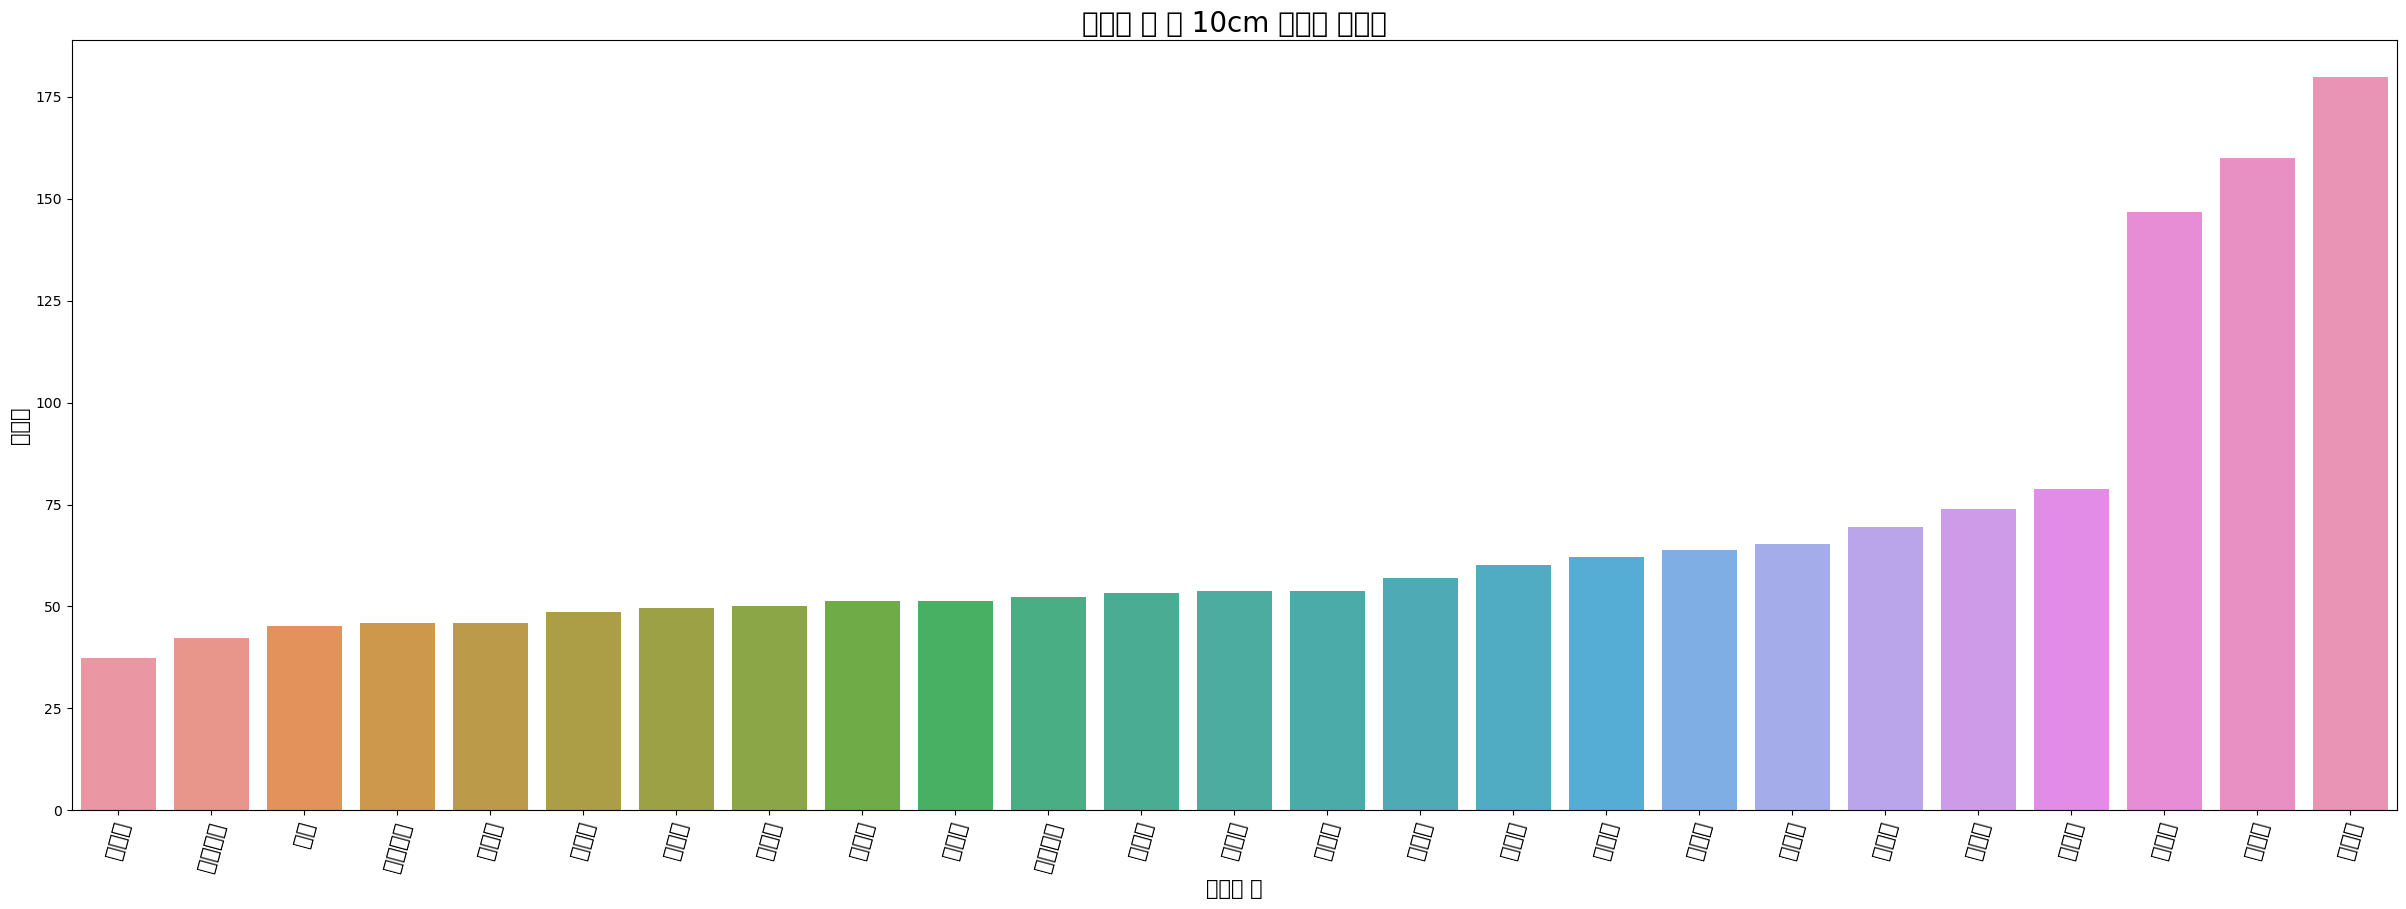

In [7]:
# 서울시 구 별 10cm 침수심 강우량 시각화
fig = plt.figure(figsize = (30, 10))

ax = fig.add_subplot(1, 1, 1)

plt.rc('font', family='NanumGothic')

sns.barplot(x = df_depth10["SGG_NM"], y = df_depth10["DEPTH_10"])
plt.title("서울시 구 별 10cm 침수심 강우량", size = 20)
ax.set_xticklabels(df_depth10["SGG_NM"], rotation = 75, fontsize = 15)
plt.ylabel("강우량", size = 15)
plt.xlabel("서울시 구", size = 15)

plt.show()

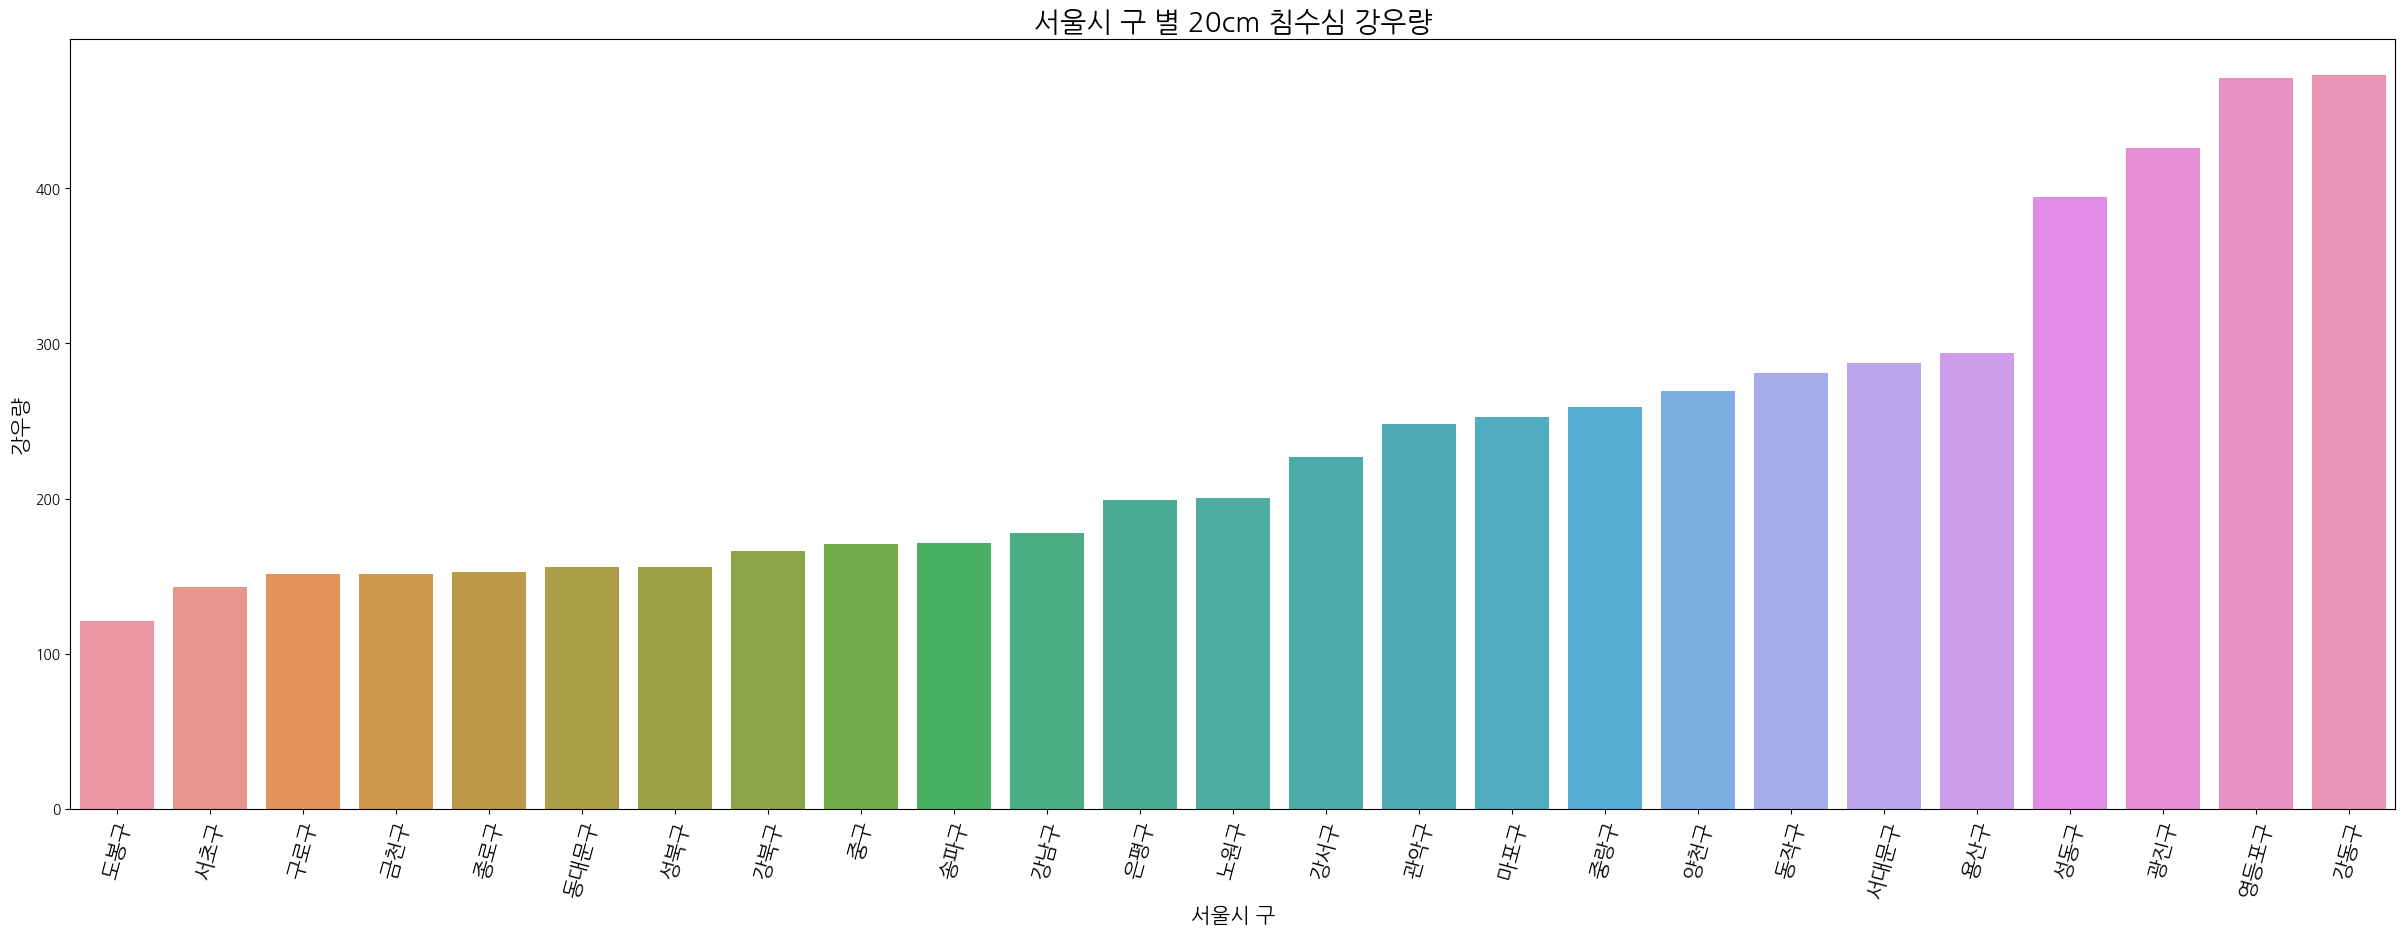

In [8]:
# 서울시 구 별 20cm 침수심 강우량 시각화
fig = plt.figure(figsize = (30, 10))

ax = fig.add_subplot(1, 1, 1)

plt.rc('font', family='NanumGothic')

sns.barplot(x = df_depth20["SGG_NM"], y = df_depth20["DEPTH_20"])
plt.title("서울시 구 별 20cm 침수심 강우량", size = 20)
ax.set_xticklabels(df_depth20["SGG_NM"], rotation = 75, fontsize = 15)
plt.ylabel("강우량", size = 15)
plt.xlabel("서울시 구", size = 15)

plt.show()

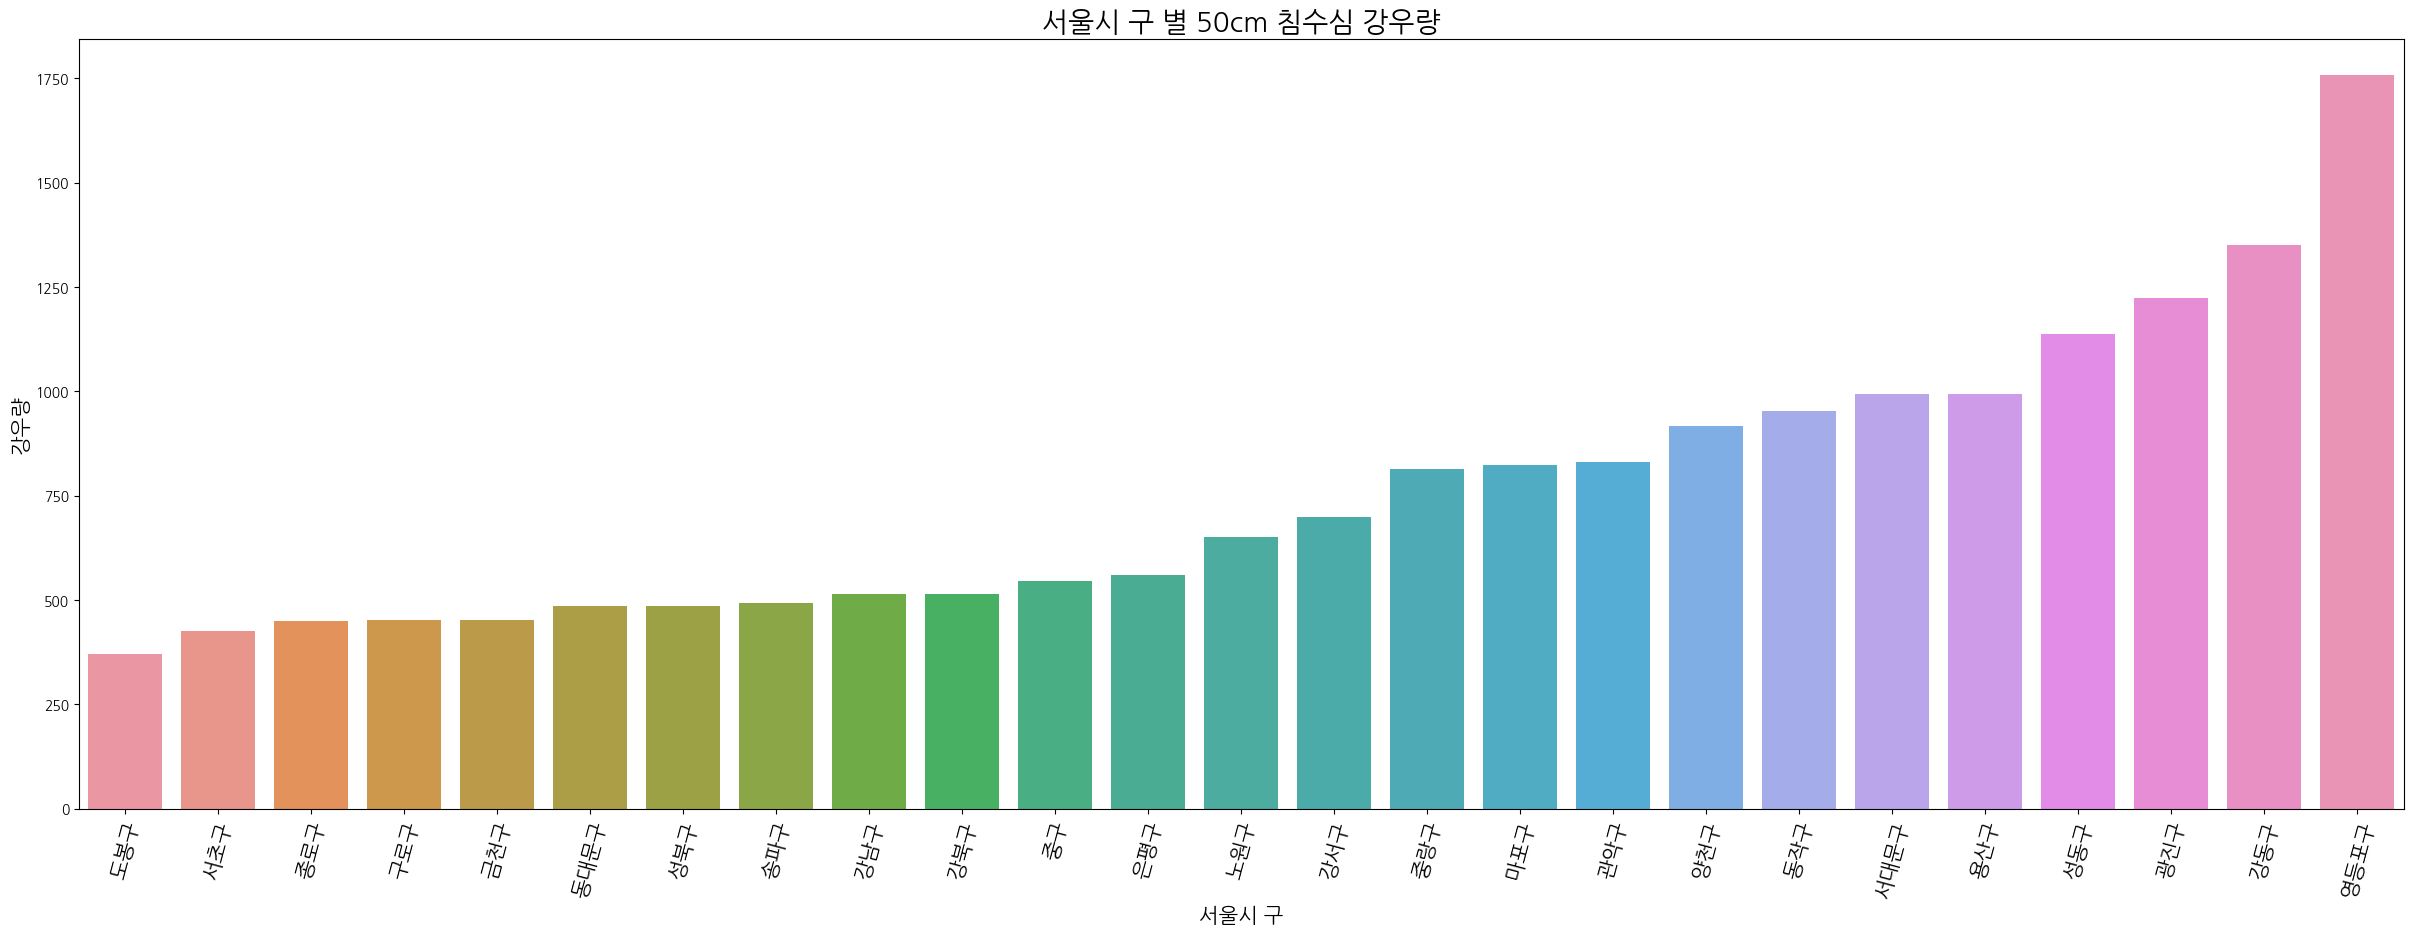

In [9]:
# 서울시 구 별 50cm 침수심 강우량 시각화
fig = plt.figure(figsize = (30, 10))

ax = fig.add_subplot(1, 1, 1)

plt.rc('font', family='NanumGothic')

sns.barplot(x = df_depth50["SGG_NM"], y = df_depth50["DEPTH_50"])
plt.title("서울시 구 별 50cm 침수심 강우량", size = 20)
ax.set_xticklabels(df_depth50["SGG_NM"], rotation = 75, fontsize = 15)
plt.ylabel("강우량", size = 15)
plt.xlabel("서울시 구", size = 15)

plt.show()

## 수해대피소 데이터 전처리

In [10]:
shelter = pd.read_csv("./data/서울시 수해대피소 공간정보.csv", encoding='utf-8')

In [13]:
li = []
for i in range(shelter.shape[0]):
    if str(shelter['행정동 코드'][i])[2:5] == '110':
        li.append('종로구')
    elif str(shelter['행정동 코드'][i])[2:5] == '140':
        li.append('중구')
    elif str(shelter['행정동 코드'][i])[2:5] == '170':
        li.append('용산구')
    elif str(shelter['행정동 코드'][i])[2:5] == '200':
        li.append('성동구')
    elif str(shelter['행정동 코드'][i])[2:5] == '215':
        li.append('광진구')
    elif str(shelter['행정동 코드'][i])[2:5] == '230':
        li.append('동대문구')
    elif str(shelter['행정동 코드'][i])[2:5] == '260':
        li.append('중랑구')
    elif str(shelter['행정동 코드'][i])[2:5] == '290':
        li.append('성북구')
    elif str(shelter['행정동 코드'][i])[2:5] == '305':
        li.append('강북구')
    elif str(shelter['행정동 코드'][i])[2:5] == '320':
        li.append('도봉구')
    elif str(shelter['행정동 코드'][i])[2:5] == '350':
        li.append('노원구')
    elif str(shelter['행정동 코드'][i])[2:5] == '380':
        li.append('은평구')
    elif str(shelter['행정동 코드'][i])[2:5] == '410':
        li.append('서대문구')
    elif str(shelter['행정동 코드'][i])[2:5] == '440':
        li.append('마포구')
    elif str(shelter['행정동 코드'][i])[2:5] == '470':
        li.append('양천구')
    elif str(shelter['행정동 코드'][i])[2:5] == '500':
        li.append('강서구')
    elif str(shelter['행정동 코드'][i])[2:5] == '530':
        li.append('구로구')
    elif str(shelter['행정동 코드'][i])[2:5] == '545':
        li.append('금천구')
    elif str(shelter['행정동 코드'][i])[2:5] == '560':
        li.append('영등포구')
    elif str(shelter['행정동 코드'][i])[2:5] == '590':
        li.append('동작구')
    elif str(shelter['행정동 코드'][i])[2:5] == '620':
        li.append('관악구')
    elif str(shelter['행정동 코드'][i])[2:5] == '650':
        li.append('서초구')
    elif str(shelter['행정동 코드'][i])[2:5] == '680':
        li.append('강남구')
    elif str(shelter['행정동 코드'][i])[2:5] == '710':
        li.append('송파구')
    elif str(shelter['행정동 코드'][i])[2:5] == '740':
        li.append('강동구')

In [14]:
shelter['구'] = li

## 구 별 수해대피소 수 분석

In [15]:
shelter2 = shelter['구'].value_counts().to_frame()
shelter2 = shelter2.reset_index()
shelter2.columns = ["구", "대피소 수"]
shelter2.sort_values(by = "대피소 수", ascending = True).head()

,구,대피소 수
24,중구,2
23,금천구,4
22,은평구,5
21,서초구,11
20,성동구,18


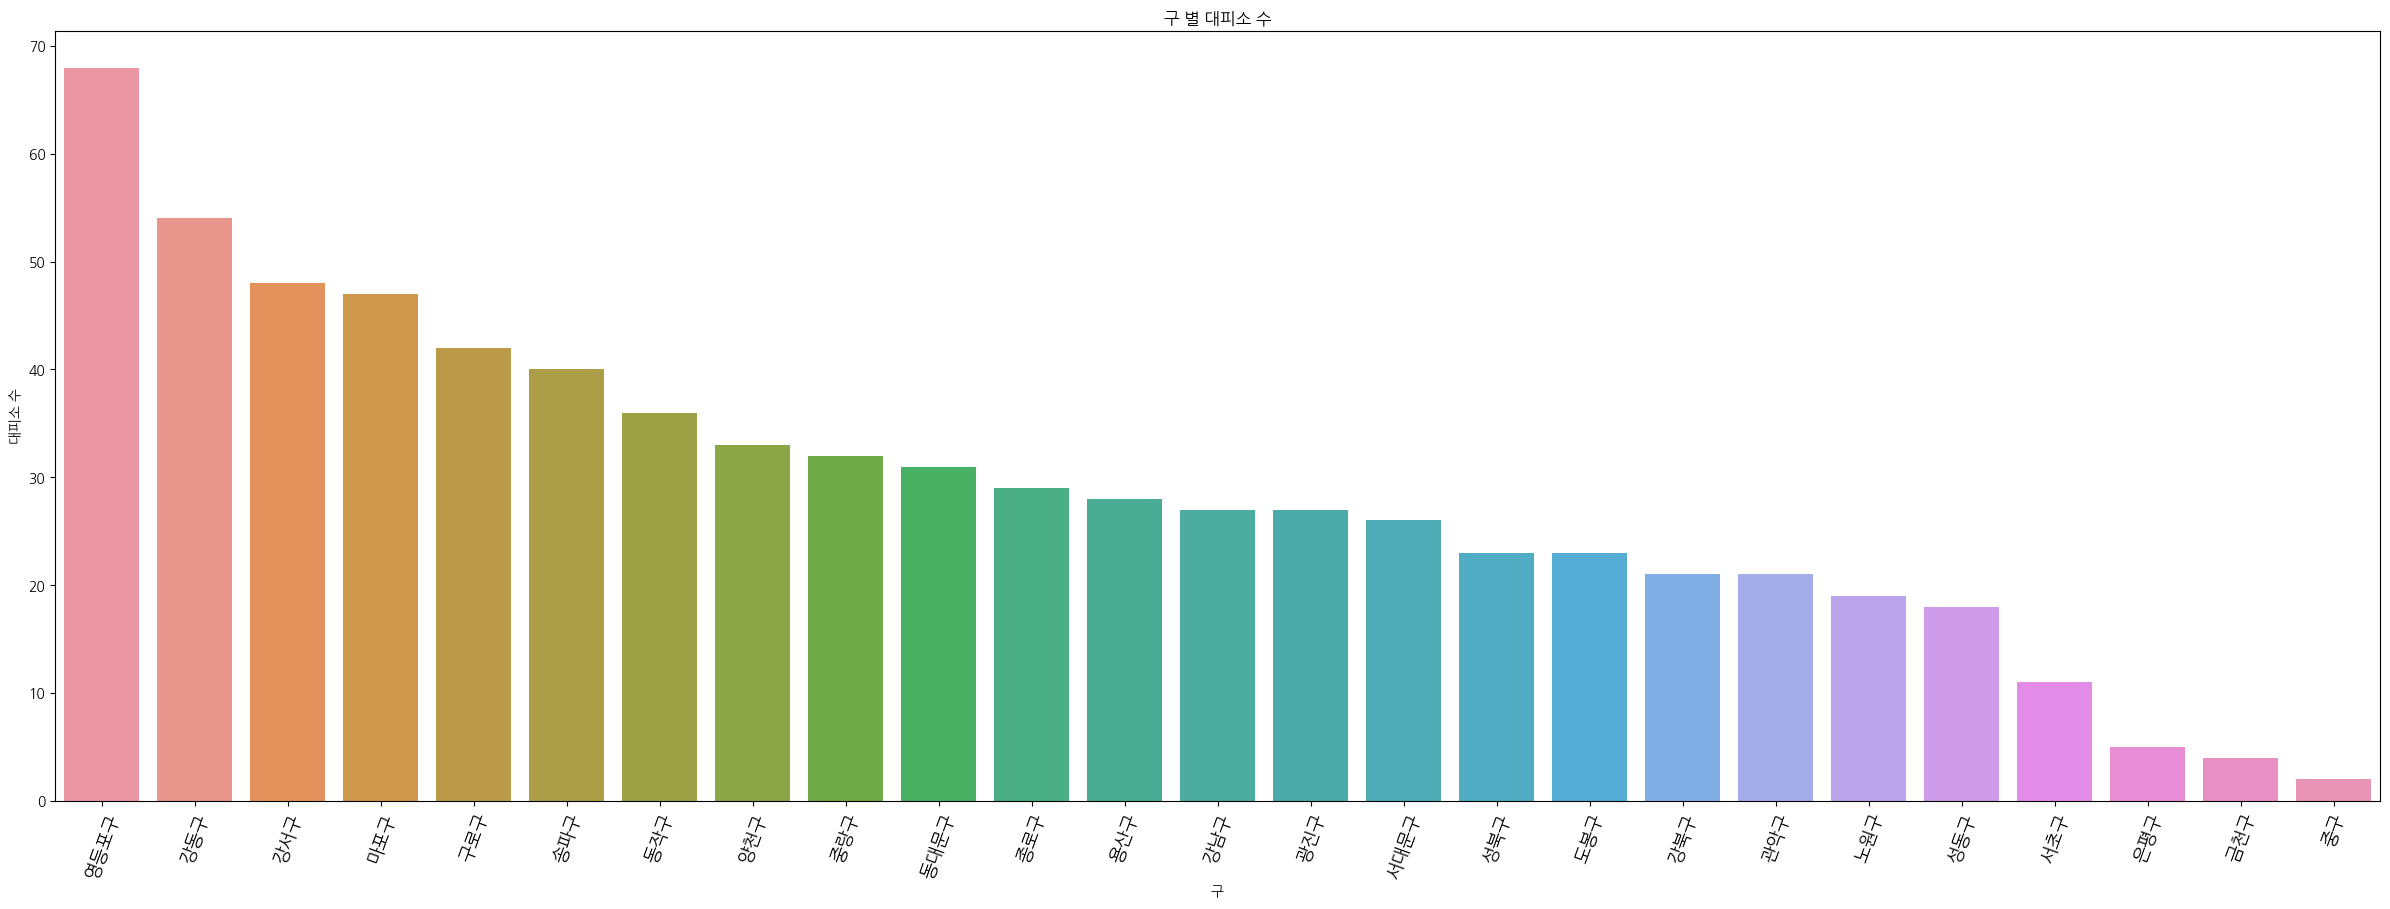

In [16]:
df_total = shelter2.sort_values(by = "대피소 수", ascending = True)

plt.figure(figsize = (30, 10))
plt.rc('font', family='NanumGothic')
plt.xticks(rotation = 70, fontsize = 13)
plt.title("구 별 대피소 수")
sns.barplot(shelter2["구"], shelter2["대피소 수"])
plt.show()

- 금천구에 수해대피소가 4개밖에 존재하지 않음을 확인할 수 있음

## 기초생활수급자 데이터 시각화

- 코드가 pdf 파일과 다소 다릅니다.

In [17]:
df = pd.read_csv("./data/서울시 국민기초생활보장 수급자 (동별) 통계.csv", encoding = "utf-8")

In [18]:
df1 = df[["동별(2)", "동별(3)", "2021"]]

In [19]:
df1.columns = ["구", "동", "소계"]

In [20]:
df2 = df1[df1["구"] == "금천구"]

In [21]:
df2.reset_index(drop = True)

,구,동,소계
0,금천구,소계,9271
1,금천구,가산동,693
2,금천구,독산1동,1307
3,금천구,독산2동,992
4,금천구,독산3동,878
5,금천구,독산4동,687
6,금천구,시흥1동,1245
7,금천구,시흥2동,963
8,금천구,시흥3동,299
9,금천구,시흥4동,923


In [22]:
df2["소계"] = df2["소계"].astype(int)

In [23]:
df2.sort_values(by = "소계", ascending = False)

,구,동,소계
314,금천구,소계,9271
316,금천구,독산1동,1307
324,금천구,시흥5동,1279
320,금천구,시흥1동,1245
317,금천구,독산2동,992
321,금천구,시흥2동,963
323,금천구,시흥4동,923
318,금천구,독산3동,878
315,금천구,가산동,693
319,금천구,독산4동,687


- 금천구 독산1동의 재난 약자 수(기초생활수급자 수)가 가장 많음을 확인할 수 있음

## 수해대피소 유형 분석

In [24]:
idx1 = np.array(shelter[shelter["대피소 명칭"].str.contains("주민센터")].index)
idx2 = np.array(shelter[shelter["대피소 명칭"].str.contains("학교")].index)
idx3 = np.array(shelter[shelter["대피소 명칭"].str.contains("교회")].index)
idx4 = np.array(shelter[shelter["대피소 명칭"].str.contains("경로당")].index)

In [25]:
idx5 = np.concatenate((idx1, idx2, idx3, idx4))
idx5.sort()

In [27]:
idx5 = list(idx5)

In [33]:
shelter3 = shelter.iloc[idx5, :]
shelter3.shape[0] / shelter.shape[0]

0.8867132867132868

- 주민센터, 학교, 교회, 경로당의 수가 전체 수해대피소 유형의 89%를 차지함을 확인할 수 있음

## 재난 약자 위치 생성

- 경계점 좌표 생성
    - 김밥친구 (126.889631, 37.4524924)
    - 카포스 대송자동차공업사 (126.892401, 37.4521075)
    - 독산주공14단지아파트 (126.886557, 37.4601029)
    - 독산중앙하이츠빌아파트 (126.888709, 37.4647542)
    - 서울 금천구 두산로3길 17 (126.888653, 37.4713315)
    - 관악농협 신독산지점 (126.894506, 37.4735534)
    - 다원우리여행사 (126.896775, 37.4758800)
    - 가산초등학교 (126.896422, 37.4779520)
    - 금천햇살요양원 (126.898187, 37.4770886)
    - 세븐일레븐 금천마루점 (126.897064, 37.4634464)
    - 금천연세로이소아청소년과의원 (126.896809, 37.4596259)
    - 관악농협 금천구청역지점 (126.893691, 37.4582085)

In [34]:
boundary_coords = [
    (126.889631, 37.4524924), (126.892401, 37.4521075), (126.886557, 37.4601029),
    (126.888709, 37.4647542), (126.888653, 37.4713315), (126.894506, 37.4735534),
    (126.896775, 37.4758800), (126.896422, 37.4779520), (126.898187, 37.4770886),
    (126.897064, 37.4634464), (126.896809, 37.4596259), (126.893691, 37.4582085)
]
boundary_polygon = Polygon(boundary_coords)

# 난수 좌표 생성
num_points = 1307  
points = [] 

while len(points) < num_points:
    x = random.uniform(126.886557, 126.898187)
    y = random.uniform(37.4521075, 37.4779520)
    point = Point(x, y)

    if boundary_polygon.contains(point):
        points.append((x, y))

# 생성된 좌표 출력
for point in points:
    print(point)

(126.88937948516065, 37.458868533015156)
(126.88835421382444, 37.457980342181884)
(126.89497223502734, 37.46053838511361)
(126.89479626753072, 37.46724582318628)
(126.89675704829442, 37.46952559241918)
(126.89666569264138, 37.4693397485472)
(126.89566264064078, 37.46218441524684)
(126.89320468601711, 37.46022130796499)
(126.89655605676506, 37.46326219287157)
(126.89120224709964, 37.46172776474327)
(126.89444047410389, 37.472472173539465)
(126.89527453804337, 37.46331223012267)
(126.8910978278752, 37.460199718411396)
(126.89399054903917, 37.461079689953785)
(126.89648875552312, 37.46585217442132)
(126.89192158695226, 37.46311201248782)
(126.89547693237965, 37.46981577342448)
(126.8911662157663, 37.4702495804247)
(126.88965492238377, 37.468782422896346)
(126.89147965590287, 37.46858195991263)
(126.89109079038398, 37.46120235166471)
(126.89303219879446, 37.47066777999041)
(126.89144187573535, 37.458804413624854)
(126.89536214681875, 37.46651450598741)
(126.8909507257238, 37.46537120289991

In [37]:
df_point = pd.DataFrame(points)
df_point.columns = ["X", "Y"]
df_point
df_point.to_csv('./data/기초생활수급자_독산1동.csv', index = False, encoding="utf-8-sig")

## P-median 분석 진행

In [44]:
shelter = pd.read_csv("./data/대피소위치_가중치포함.csv", encoding="utf-8-sig")
people = pd.read_csv("./data/기초생활수급자_독산1동.csv", encoding="utf-8-sig")

In [45]:
people_lat = people['Y']
people_long = people['X']

shelter_lat = shelter['Y']
shelter_long = shelter['X']

In [46]:
mm = MinMaxScaler()
shelter["weight"] = mm.fit_transform(shelter[["weight"]])

for j in range(shelter.shape[0]):
    shelter["weight"][j] = shelter["weight"][j]/2 + 1
    
c = []
for i in range(people.shape[0]):
    list_ = []
    for j in range(shelter.shape[0]):
        start = (float(people_lat[i]), float(people_long[i]))
        goal = (float(shelter_lat[j]), float(shelter_long[j]))
        list_.append(haversine(start, goal) * (shelter["weight"][j]))
    c.append(list_)  

- 가중치 아이디어(1 ~ 1.5) -> 비슷한 거리에 있을 때 더 수용 가능한 곳으로 가도록 하게 하기 위해)
    -  shelter['weight'][j] : j번째 시설의 해당 weight (학교가 가장 대피하기 좋은 장소(수용인원이 많음) 기준 1로 두고 나머지 유형의 대피소의 가중치는 학교 수용인원수 / 해당 유형의 대피소의 수용인원수)
    - minmaxscaling 후 2로 나누고 1을 더하기

- c : 각 시설별로 각 고객에게 서비스를 제공하는 비용(cost함수 정의 후 만들기)
- i행은 고객을 나타냄
- j열은 시설을 나타냄
- c[i][j] : i번째 고객에게 j번째 facility가 서비스를 제공하는 비용

- m : 고객의 수(기초수급자의 수 : 9271)
- n : 시설의 수(공공기관의 수 : 155)
- p : 찾을 시설의 수(면적으로 나누기)

In [57]:
m = 1307
n = 155 
p = 6

# 문제 정의
prob = LpProblem("p-median", LpMinimize)

# 결정 변수 정의
x = LpVariable.dicts("x", [(i,j) for i in range(m) for j in range(n)], 0, 1, LpBinary)
y = LpVariable.dicts("y", [j for j in range(n)], 0, 1, LpBinary)

- x는 이진 결정 변수의 dictionary를 정의
    - 각 변수는 i고객이 j시설에 할당되었는지 여부를 나타냄
    
- 각각의 시설이 열렸는지 닫혔는지?

In [58]:
# 목적함수 정의
prob += lpSum([c[i][j] * x[(i,j)] for i in range(m) for j in range(n)])

- c[i][j] : i번째 사람에 대한 j번째 시설에 대한 cost
- x[(i, j)] : i번째 사람이 j번째 faclity에 영향을 받고 있는지 여부를 나타냄
- 위를 minimize하는 방향으로 진행

In [59]:
for i in range(m):
    prob += lpSum([x[(i,j)] for j in range(n)]) == 1
# 한 사람은(i번째 사람) 한 시설(j번째 시설)에만 영향을 받아야 함
    
for i in range(m):
    for j in range(n):
        prob += x[(i,j)] <= y[j]
# 시설이 열려 있어야지 영향을 받고 있는지 여부를 0과 1로 결정할 수 있음
                 
prob += lpSum([y[j] for j in range(n)]) == p
# 시설이 열려있는 수는 우리가 원하는 시설의 수와 같아야됨

In [60]:
# branch-and-bound algorithm을 이용해 문제 해결하기
random.seed(123)
prob.solve(PULP_CBC_CMD(gapRel=0.0, threads=1, timeLimit=120))

1

- gapRel = 0.0 : 주어진 시간 제한 내에서 최상의 솔루션을 찾을 때까지 최적의 솔루션을 계속 검색
- threads = 1 : 병렬 컴퓨팅에 사용할 수 있는 thread 수를 의미, 단일 thread 모들에서 실행한다는 의미인 1로 실행 
- timeLimit = 120 : 솔루션을 찾는 데 사용할 수 있는 최대 시간(초)

In [61]:
# Print results
print("Optimal objective value:", value(prob.objective))
for j in range(n):
    if y[j].value() > 0.5:
        print("Facility", j, "is located.")
#        for i in range(m):
#                if x[(i,j)].value() > 0.5:
#            print("- Customer", i, "is served.")

Optimal objective value: 324.18744718678556
Facility 12 is located.
Facility 19 is located.
Facility 30 is located.
Facility 117 is located.
Facility 122 is located.
Facility 134 is located.


In [62]:
lat = shelter['Y'].mean()
long = shelter['X'].mean()

#지도 띄우기
m = folium.Map([lat, long], zoom_start = 20)

#for n in range(shelter.shape[0]):
for n in (12, 19, 30, 117, 122, 134):
    #name = df_seoul_hospital.loc[n, "상호명"]
    #address = df_seoul_hospital.loc[n, "도로명주소"]
    popup = shelter.loc[n, 'shelter'],
    location = [shelter.loc[n, "Y"], shelter.loc[n, "X"]]
    folium.Marker(
        location = location,
        popup = popup
    ).add_to(m)
m

- 위 과정을 p = 2에 대해서도 반복하면 됩니다

In [63]:
df_result = shelter.loc[[12, 19, 30, 118, 122, 134]]

In [64]:
df_result

,shelter,X,Y,weight
12,안천중학교,126.887711,37.459185,1.000000
19,가산중학교,126.894412,37.468445,1.000000
30,서울두산초등학교,126.890988,37.467144,1.000000
118,신광교회,126.895501,37.473302,1.079567
122,금천반석교회,126.895694,37.464571,1.079567
134,이야기침례교회,126.893691,37.458208,1.079567


## 기대 효과

In [65]:
shelter11 = pd.DataFrame({"shelter" : ["가산중학교", "가산초등학교", "시흥초등학교", "안천중학교"],
                         "X" : [126.894456, 126.896308, 126.904625, 126.887484],
                         "Y" : [37.46876, 37.4781501, 37.4553258, 37.4595092], 
                          "weight" : [1, 1, 1, 1]})

In [66]:
people_lat = people['Y']
people_long = people['X']

shelter11_lat = shelter['Y']
shelter11_long = shelter['X']

mm = MinMaxScaler()
shelter11["weight"] = mm.fit_transform(shelter11[["weight"]])

for j in range(shelter11.shape[0]):
    shelter11["weight"][j] = shelter11["weight"][j]/2 + 1
    
c11 = []
for i in range(people.shape[0]):
    list_ = []
    for j in range(shelter11.shape[0]):
        start = (float(people_lat[i]), float(people_long[i]))
        goal = (float(shelter11_lat[j]), float(shelter11_long[j]))
        list_.append(haversine(start, goal) * (shelter11["weight"][j]))
    c11.append(list_)  

In [67]:
m = 1307
n = 4
p = 4

# 문제 정의
prob_new = LpProblem("p-median", LpMinimize)

# 결정 변수 정의
x = LpVariable.dicts("x", [(i,j) for i in range(m) for j in range(n)], 0, 1, LpBinary)
y = LpVariable.dicts("y", [j for j in range(n)], 0, 1, LpBinary)

In [68]:
# 목적함수 정의
prob_new += lpSum([c11[i][j] * x[(i,j)] for i in range(m) for j in range(n)])

In [69]:
for i in range(m):
    prob_new += lpSum([x[(i,j)] for j in range(n)]) == 1
# 한 사람은(i번째 사람) 한 시설(j번째 시설)에만 영향을 받아야 함
    
for i in range(m):
    for j in range(n):
        prob_new += x[(i,j)] <= y[j]
# 시설이 열려 있어야지 영향을 받고 있는지 여부를 0과 1로 결정할 수 있음
                 
prob_new += lpSum([y[j] for j in range(n)]) == p
# 시설이 열려있는 수는 우리가 원하는 시설의 수와 같아야됨

In [70]:
# branch-and-bound algorithm을 이용해 문제 해결하기
random.seed(123)
prob_new.solve(PULP_CBC_CMD(gapRel=0.0, threads=1, timeLimit=120))

1

In [71]:
# Print results
print("Optimal objective value:", value(prob_new.objective))
for j in range(n):
    if y[j].value() > 0.5:
        print("Facility", j, "is located.")
#        for i in range(m):
#                if x[(i,j)].value() > 0.5:
#                    print("- Customer", i, "is served.")

Optimal objective value: 971.7461098013224
Facility 0 is located.
Facility 1 is located.
Facility 2 is located.
Facility 3 is located.


In [72]:
lat = shelter11['Y'].mean()
long = shelter11['X'].mean()

#지도 띄우기
m = folium.Map([lat, long], zoom_start = 20)

#for n in range(shelter.shape[0]):
for n in (0, 1, 2, 3):
    #name = df_seoul_hospital.loc[n, "상호명"]
    #address = df_seoul_hospital.loc[n, "도로명주소"]
    popup = shelter11.loc[n, 'shelter'],
    location = [shelter11.loc[n, "Y"], shelter11.loc[n, "X"]]
    folium.Marker(
        location = location,
        popup = popup
    ).add_to(m)
m

In [73]:
shelter11

,shelter,X,Y,weight
0,가산중학교,126.894456,37.468760,1.0
1,가산초등학교,126.896308,37.478150,1.0
2,시흥초등학교,126.904625,37.455326,1.0
3,안천중학교,126.887484,37.459509,1.0
